In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
mit = pd.read_csv('./data/mitbih_train.csv', header=None)

In [3]:
# Separate target from data
y = mit[187]
X = mit.loc[:, :186]

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0, stratify=y)

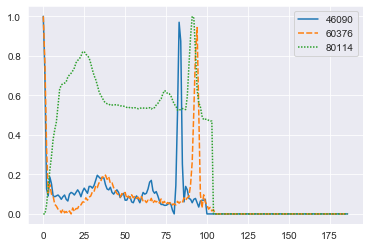

In [7]:
sns.lineplot(data=X_train.sample(3).T)

We can see three examples of different ECGs above taken from our dataset.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

### Preprocessing
Now we load in the data to predefined torch objects, TensorDataset and DataLoader, which can handle minibatching automatically for us.

In [9]:
# Convert to torch tensors
X_train, y_train, X_valid, y_valid = map(
    torch.from_numpy, (X_train.values, y_train.values, X_valid.values, y_valid.values)
)

In [10]:
# Convert to 3D tensor
X_train = X_train.unsqueeze(1)

X_valid = X_valid.unsqueeze(1)

In [11]:
# Batch size
bs = 64

train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(X_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

### Building the ResNet

We build our first model, a residual neural network (ResNet). 

First, we make a class representing a residual block. This block performs three convolutions and normalizations before adding back in the residual. In the forward method, the convolution of kernel size 1 is needed, so that the tensor shapes match up for the identity and transformed input.

Next, we construct a class for the ResNet utilizing the ResBlocks. Three residual blocks are used. They have various numbers of filters (specified by input channels and output channels). These blocks are followed by a global average pooling layer, which transforms each feature map into a scalar. Finally, the output is passed through a linear layer.

In [13]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=9, padding=4)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.id_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.id_bn = nn.BatchNorm1d(out_channels)
    
    def forward(self, x):
        # Shortcut
        identity = x
        if self.in_channels != self.out_channels:
            identity = self.id_conv(x)
        identity = self.id_bn(identity)
        
        # First convolution
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        # Second convolution
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        
        # Third convolution
        out = self.conv3(out)
        out = self.bn3(out)
        out += identity
        out = F.relu(out)
        return out
     

In [14]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.block1 = ResBlock(1, 64)
        self.block2 = ResBlock(64, 128)
        self.block3 = ResBlock(128, 128)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.lin = nn.Linear(128, 5)
    
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.pool(out)
        out = torch.flatten(out, 1)
        out = self.lin(out)
        return out

### Model Training

We train the model on our data using helper functions taken from Pytorch tutorial https://pytorch.org/tutorials/beginner/nn_tutorial.html.

Training takes significant amount of time (about an hour). 

In [15]:
def get_model():
    model = ResNet()
    opt = optim.Adam(model.parameters())
    return model, opt
    
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb.float()), yb.long())

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [16]:
model, opt = get_model()
fit(5, model, F.cross_entropy, opt, train_dl, valid_dl)

0 0.14510196512325474
1 0.11236402671730979
2 0.10132576558134603
3 0.10121184411722295
4 0.09681070879822679


### Model Testing

We test our model on the testing dataset. In this case, we can simply apply our model as a function to the raw data and store the predictions. Testing also takes nontrivial amount of time (~10 min).

Testing loss: 0.1063
Testing accuracy: 96.9%

Baseline accuracy is about 82%.

In [21]:
mit_test = pd.read_csv('./data/mitbih_test.csv', header=None)

In [22]:
mit_test.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
y_test = mit_test[187]
X_test = mit_test.loc[:, :186]

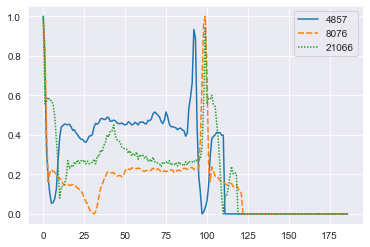

In [24]:
sns.lineplot(data=X_test.sample(3).T)

In [25]:
X_test, y_test = map(torch.from_numpy, (X_test.values, y_test.values))

In [27]:
X_test = X_test.unsqueeze(1)

In [32]:
model.eval()
with torch.no_grad():
    preds = model(X_test.float())

In [33]:
preds.size()

torch.Size([21892, 5])

In [41]:
F.cross_entropy(preds, y_test.long())

tensor(0.1063)

In [43]:
y_test.numpy()

array([0., 0., 0., ..., 4., 4., 4.])

In [72]:
np_preds = torch.argmax(F.softmax(preds, dim=1), axis=1).numpy()

In [70]:
from sklearn.metrics import accuracy_score, f1_score

In [73]:
accuracy_score(y_test.numpy(), np_preds)

0.9689841037822036